# 1. Aquisição e transformação dos dados

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [3]:
w_wine = pd.read_csv('datasets/winequality-white.csv', sep = ';')

In [4]:
x = w_wine.iloc[:, 0:-1]
y = w_wine.iloc[:, -1]

In [5]:
column_name = w_wine.drop(columns=['quality']).columns

# In general, it's a good idea to scale the data prior to PCA.
scaler = StandardScaler()
scaler.fit(x)
X=scaler.transform(x)    
pca = PCA()
x_new = pca.fit_transform(x)

def myplot(pcs,loadings, target, column_name, labels=None):
    xs = pcs[:,0]
    ys = pcs[:,1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    pc1 = xs*scalex
    pc2 = ys*scaley

    df = {'pc1': pc1, 'pc2': pc2, 'quality': target}
    df = pd.DataFrame(data=df)

    fig = px.scatter(df, x='pc1', y='pc2', color='quality', color_continuous_scale = "rainbow")

    for i, feature in enumerate(column_name):
        fig.add_shape(type='line',
                      x0=0,
                      y0=0,
                      x1=loadings[i,0],
                      y1=loadings[i,1]
                    )
        fig.add_annotation(x=loadings[i,0],
                           y=loadings[i,1],
                           ax=0,
                           ay=0,
                           xanchor="center",
                           yanchor="bottom",
                           text = feature,
                           font=dict(size=18,
                                     color="crimson"
                                    )
                          )
    fig.show()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]), y, column_name)

In [6]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 90.97,  98.9 ,  99.92,  99.97, 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  , 100.  ])

In [7]:
from sklearn.preprocessing import scale 
x_reduced = scale(x_new)[:,:7]

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=111)
x_train = np.array(x_train)
x_test = np.array(x_test)

# 2. ADASYN e Undersampling

In [ ]:
wg = y_train.value_counts()
wg[8] = 0.2*wg[6]
wg[4] = 0.2*wg[6]
wg[9] = 0.1*wg[6]
wg[3] = 0.15*wg[6]

6    1658
5    1084
7     649
8     142
4     123
3      13
9       4
Name: quality, dtype: int64

In [ ]:
strategy1_w = {3:wg[3], 4:wg[4], 5:wg[5], 6:wg[6], 7:wg[7], 8:wg[8], 9:wg[9]}
over = ADASYN(sampling_strategy=strategy1_w)

In [ ]:
wg[5] = 0.7*wg[5]
wg[6] = 0.5*wg[6]

In [ ]:
strategy2_w = {3:wg[3], 4:wg[4], 5:wg[5], 6:wg[6], 7:wg[7], 8:wg[8], 9:wg[9]}
under = RandomUnderSampler(sampling_strategy=strategy2_w)

In [ ]:
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
x_train, y_train = pipeline.fit_resample(x_train, y_train)

# 3. Implementação da RNA

## 3.1 Descoberta dos hyperparâmetros (Otimização Bayseana)

In [ ]:
# Import packages
from sklearn.model_selection import cross_val_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, recall_score, f1_score
from bayes_opt import BayesianOptimization
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
from scikeras.wrappers import KerasClassifier
from sklearn import metrics

pd.set_option("display.max_columns", None)

In [ ]:
score_acc = make_scorer(accuracy_score)

In [ ]:
def logistic(w3, w4, w5, w6, w7, w8, w9):

    weights = [w3, w4, w5, w6, w7, w8, w9]

    w = {}
    for i in range(0, len(weights)):
        index = i+3
        w[index] = weights[i]

    lr = LogisticRegression(random_state = 50, solver = 'liblinear', class_weight = w)

    return lr

In [ ]:
def evaluate_model(w3, w4, w5, w6, w7, w8, w9):
    
    lr = logistic(w3, w4, w5, w6, w7, w8, w9)

    lr.fit(x_train, y_train)

    y_pred = lr.predict(x_train)

    score = f1_score(y_train, y_pred, average='macro') 

    # score = cross_val_score(nn, x_train, y_train, scoring=score_acc, cv=5, fit_params={'callbacks':[es]}).mean()
    
    return score

In [ ]:
pbounds = {'w3': (0,100),
            'w4': (0,100),
            'w5': (0,100),
            'w6': (0,100),
            'w7': (0,100),
            'w8': (0,100),
            'w9': (0,100),
            }

optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1
)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

optimizer.maximize(init_points=100, n_iter=80,)

|   iter    |  target   |    w3     |    w4     |    w5     |    w6     |    w7     |    w8     |    w9     |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.1294    | 41.7      | 72.03     | 0.01144   | 30.23     | 14.68     | 9.234     | 18.63     |
| 2         | 0.2101    | 34.56     | 39.68     | 53.88     | 41.92     | 68.52     | 20.45     | 87.81     |
| 3         | 0.1581    | 2.739     | 67.05     | 41.73     | 55.87     | 14.04     | 19.81     | 80.07     |
| 4         | 0.1807    | 96.83     | 31.34     | 69.23     | 87.64     | 89.46     | 8.504     | 3.905     |
| 5         | 0.1761    | 16.98     | 87.81     | 9.835     | 42.11     | 95.79     | 53.32     | 69.19     |
| 6         | 0.1459    | 31.55     | 68.65     | 83.46     | 1.829     | 75.01     | 98.89     | 74.82     |
| 7         | 0.1703    | 28.04     | 78.93     | 10.32     | 44.79     | 90.86     | 29.36     | 28.78     |
| 8       

In [ ]:
params_ = optimizer.max['params']
params_

{'w3': 100.0,
 'w4': 99.818383367693,
 'w5': 13.80574569454435,
 'w6': 14.147448496500513,
 'w7': 36.518471893859804,
 'w8': 18.8487286350003,
 'w9': 20.46637102980241}

In [ ]:
lr = logistic(params_["w3"], params_["w4"], params_["w5"], params_["w6"], params_["w7"],
                params_["w8"], params_["w9"])


lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

In [ ]:
lr.score(x_test, y_test)

0.49387755102040815

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
cm

array([[  0,   1,   2,   3,   1,   0,   0],
       [  0,   9,  15,  13,   3,   0,   0],
       [  0,  19, 185, 143,  26,   0,   0],
       [  1,   1,  95, 297, 146,   0,   0],
       [  0,   0,  17, 100, 114,   0,   0],
       [  0,   1,   3,   4,  25,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0]])

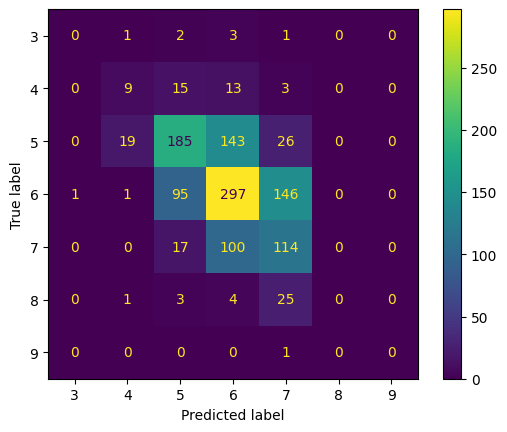

In [ ]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [3,4,5,6,7,8,9])
cm_display.plot()

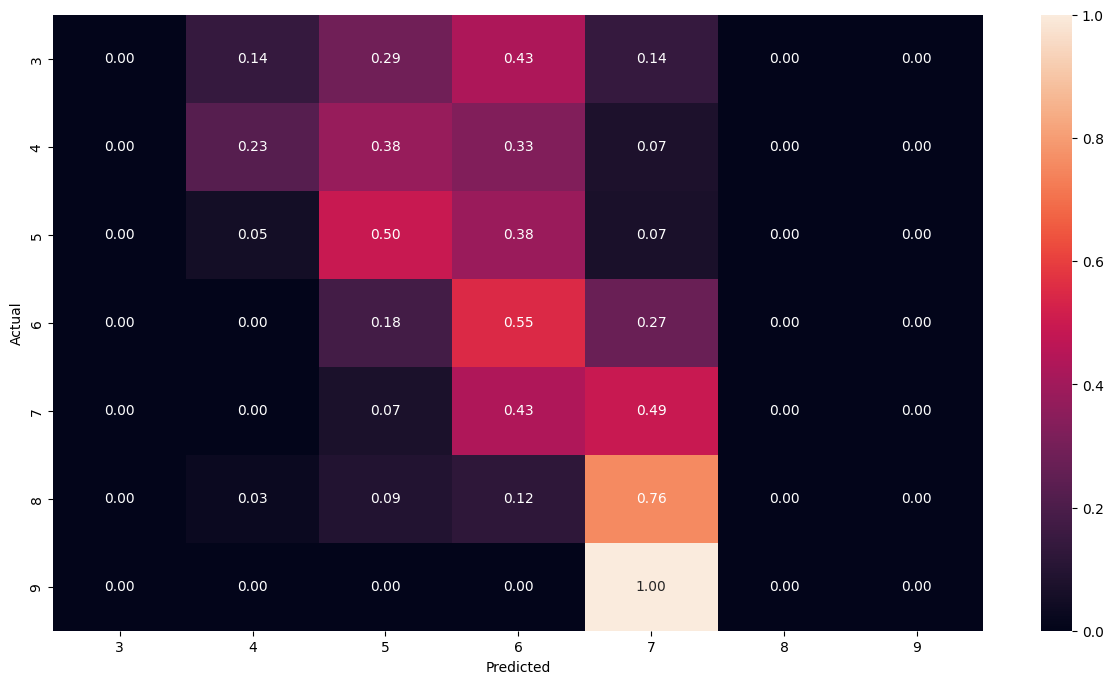

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[3,4,5,6,7,8,9], yticklabels=[3,4,5,6,7,8,9])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)